In [ ]:
!pip install modAL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [ ]:
# load the Pima Indians Diabetes dataset
data = pd.read_csv('/content/riceClassification.csv')
data.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
# separate the features (X) and targets (y)
X = data.drop('Class', axis=1).values
y = data['Class'].values

In [ ]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
# define the ActiveLearner models
learner_uncertainty = ActiveLearner(estimator=SVC(probability=True), query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)
learner_margin = ActiveLearner(estimator=SVC(probability=True), query_strategy=margin_sampling, X_training=X_train, y_training=y_train)
learner_entropy = ActiveLearner(estimator=SVC(probability=True), query_strategy=entropy_sampling, X_training=X_train, y_training=y_train)

# set the number of iterations and batch size
num_iterations = 10
batch_size = 5

# initialize lists to store the accuracy values
acc_uncertainty = []
acc_margin = []
acc_entropy = []
train_acc_uncertainty = []
train_acc_margin = []
train_acc_entropy = []

# perform active learning iterations
for i in range(num_iterations):
    # query the next batch of instances using the active learning strategy
    query_idx_uncertainty, _ = learner_uncertainty.query(X_test, n_instances=batch_size)
    query_idx_margin, _ = learner_margin.query(X_test, n_instances=batch_size)
    query_idx_entropy, _ = learner_entropy.query(X_test, n_instances=batch_size)

    # request the labels for the queried instances
    y_true_uncertainty = y_test[query_idx_uncertainty]
    y_true_margin = y_test[query_idx_margin]
    y_true_entropy = y_test[query_idx_entropy]

    # predict the labels of the queried instances
    y_pred_uncertainty = learner_uncertainty.predict(X_test[query_idx_uncertainty])
    y_pred_margin = learner_margin.predict(X_test[query_idx_margin])
    y_pred_entropy = learner_entropy.predict(X_test[query_idx_entropy])

    # teach the model the newly labeled instances
    learner_uncertainty.teach(X_test[query_idx_uncertainty], y_true_uncertainty)
    learner_margin.teach(X_test[query_idx_margin], y_true_margin)
    learner_entropy.teach(X_test[query_idx_entropy], y_true_entropy)

    # evaluate the model's accuracy on the training set
    train_acc_uncertainty.append(learner_uncertainty.score(X_train, y_train))
    train_acc_margin.append(learner_margin.score(X_train, y_train))
    train_acc_entropy.append(learner_entropy.score(X_train, y_train))

    # evaluate the model's accuracy on the test set
    y_pred_uncertainty_all = learner_uncertainty.predict(X_test)
    y_pred_margin_all = learner_margin.predict(X_test)
    y_pred_entropy_all = learner_entropy.predict(X_test)

    acc_uncertainty.append(accuracy_score(y_test, y_pred_uncertainty_all))
    acc_margin.append(accuracy_score(y_test, y_pred_margin_all))
    acc_entropy.append(accuracy_score(y_test, y_pred_entropy_all))

    # print the results for each iteration
    print(f"Iteration {i+1}")
    print(f"Training accuracy with uncertainty sampling: {train_acc_uncertainty[-1]}")
    print(f"Training accuracy with margin sampling: {train_acc_margin[-1]}")
    print(f"Training accuracy with entropy sampling: {train_acc_entropy[-1]}")
    print(f"Test accuracy with uncertainty sampling: {acc_uncertainty[-1]}")
    print(f"Test accuracy with margin sampling: {acc_margin[-1]}")
    print(f"Test accuracy with entropy sampling: {acc_entropy[-1]}")

Iteration 1
Training accuracy with uncertainty sampling: 0.9936046191916414
Training accuracy with margin sampling: 0.9786733571624966
Training accuracy with entropy sampling: 0.9836046191916414
Test accuracy with uncertainty sampling: 0.9842543304921639
Test accuracy with margin sampling: 0.9762543304921639
Test accuracy with entropy sampling: 0.9752543304921639
Iteration 2
Training accuracy with uncertainty sampling: 0.9935358812207864
Training accuracy with margin sampling: 0.9785358812207864
Training accuracy with entropy sampling: 0.9835358812207864
Test accuracy with uncertainty sampling: 0.9842543304921639
Test accuracy with margin sampling: 0.9762543304921639
Test accuracy with entropy sampling: 0.9752543304921639
Iteration 3
Training accuracy with uncertainty sampling: 0.9933984052790762
Training accuracy with margin sampling: 0.9783984052790762
Training accuracy with entropy sampling: 0.9833984052790762
Test accuracy with uncertainty sampling: 0.9842543304921639
Test accuracy

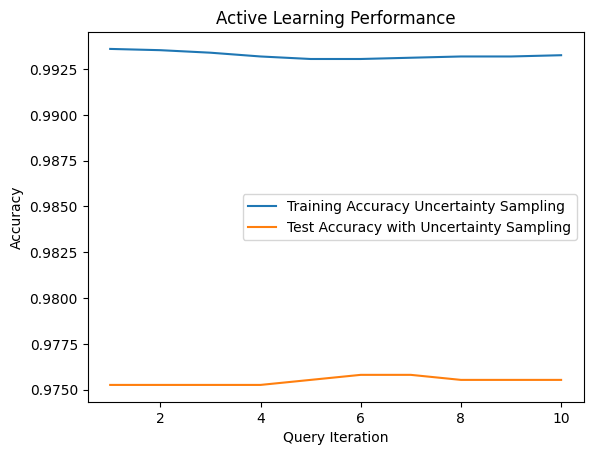

In [ ]:
# plot the results
plt.plot(range(1, num_iterations+1),  train_acc_uncertainty , label='Training Accuracy Uncertainty Sampling')

plt.plot(range(1, num_iterations+1), acc_uncertainty , label='Test Accuracy with Uncertainty Sampling')

plt.xlabel('Query Iteration')
plt.ylabel('Accuracy')
plt.title('Active Learning Performance')
plt.legend()
plt.show()

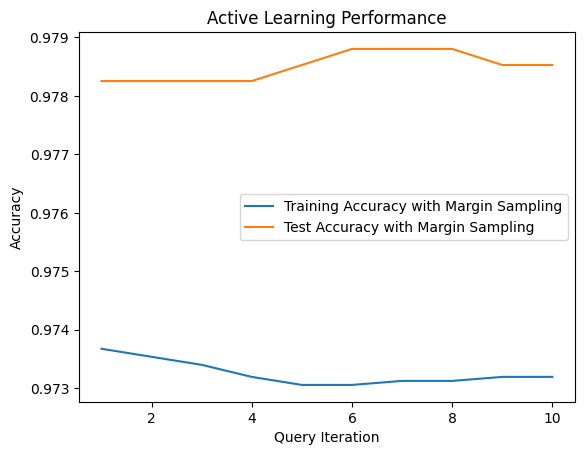

In [ ]:
plt.plot(range(1, num_iterations+1), train_acc_margin, label='Training Accuracy with Margin Sampling')
plt.plot(range(1, num_iterations+1),  acc_margin, label='Test Accuracy with Margin Sampling')
plt.xlabel('Query Iteration')
plt.ylabel('Accuracy')
plt.title('Active Learning Performance')
plt.legend()
plt.show()

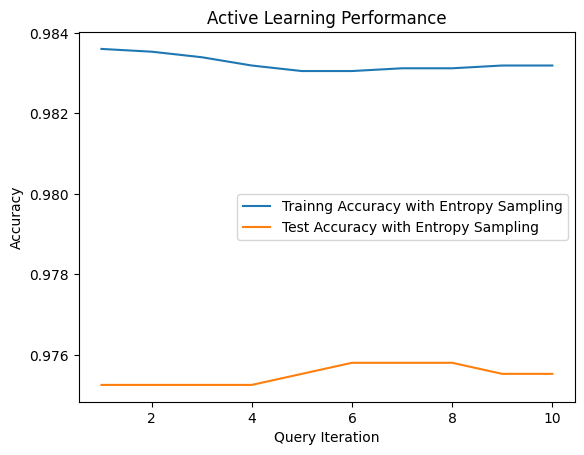

In [ ]:
plt.plot(range(1, num_iterations+1),  train_acc_entropy, label='Trainng Accuracy with Entropy Sampling')
plt.plot(range(1, num_iterations+1), acc_entropy, label='Test Accuracy with Entropy Sampling')
plt.xlabel('Query Iteration')
plt.ylabel('Accuracy')
plt.title('Active Learning Performance')
plt.legend()
plt.show()